In [1]:
!pip install transformers datasets trl huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 6.0 MB/s eta 0:00:00a 0:00:01


In [2]:

from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from trl import SFTConfig, SFTTrainer, setup_chat_format
import torch
model_name = "Qwen/Qwen2.5-7B-Instruct"

# Load model across multiple GPUs
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",  # Enables multi-GPU support
    torch_dtype=torch.bfloat16,  # Reduce memory usage
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
finetune_name = "ESI"

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

# Generate the train_prompt:

In [3]:
train_prompt_style = """
### Instruction:
You are an expert with advanced knowledge in solving temporal reasoning problems.
Before answering, classify the task given and then create a step-by-step reasoning to ensure a logical and accurate response.
Please answer the following questions.

### Question:
{}
### Task:
{}
### Reasoning:
{}
### Final Answer:
{}"""

In [4]:
EOS_TOKEN = tokenizer.eos_token  # Must add EOS_TOKEN

def formatting_prompts_func(examples):
    inputs = examples["question"]
    cots = examples["reasoning"]  # Có thể chứa giá trị None
    outputs = examples["reasoner_answer"]
    tasks = examples["task"]
    texts = []

    for input, task, cot_list, output in zip(inputs,tasks, cots, outputs ):
        if cot_list is None:  
            cot = "N/A"
        elif isinstance(cot_list, list):  
            cot = "\n".join(map(str, cot_list))
        else:  
            cot = str(cot_list)

        text = train_prompt_style.format(input, task, cot, output) + EOS_TOKEN
        texts.append(text)

    return {"text": texts}

# Split data:

In [5]:
from datasets import load_dataset
dataset = load_dataset("ESITime/timesi-arithmetic", split = "train",trust_remote_code=True)
dataset = dataset.shuffle(seed=42)
split_dataset = dataset.train_test_split(test_size=0.2)

train_dataset = split_dataset["train"]
val_dataset = split_dataset["test"]

train_dataset = train_dataset.map(formatting_prompts_func, batched=True)
val_dataset = val_dataset.map(formatting_prompts_func, batched=True)
print("val data example:")
print(val_dataset["text"][0])
print("train data example:")
print(train_dataset["text"][0])



README.md:   0%|          | 0.00/477 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5408 [00:00<?, ? examples/s]

Map:   0%|          | 0/4326 [00:00<?, ? examples/s]

Map:   0%|          | 0/1082 [00:00<?, ? examples/s]

val data example:

### Instruction:
You are an expert with advanced knowledge in solving temporal reasoning problems.
Before answering, classify the task given and then create a step-by-step reasoning to ensure a logical and accurate response.
Please answer the following questions.

### Question:
A store holds a sale every 3 months. How many sales will happen in 7 years?
### Task:
freq_compute
### Reasoning:
Step 1: Identify the given information. The store holds a sale every 3 months and we need to find out how many sales will happen in 7 years.
Step 2: Convert the total time span from years to months to match the sale frequency unit. There are 12 months in a year, so 7 years is equal to 7 * 12 months.
Step 3: Calculate the total months in 7 years. 7 * 12 = 84 months.
Step 4: Divide the total number of months (84) by the sale frequency (3 months) to find the number of sales. 84 / 3 = 28.
### Final Answer:
28 sales<|endoftext|>
train data example:

### Instruction:
You are an expert wi

# Setting up models


In [6]:
from peft import LoraConfig

# TODO: Configure LoRA parameters
# r: rank dimension for LoRA update matrices (smaller = more compression)
rank_dimension = 8
# lora_alpha: scaling factor for LoRA layers (higher = stronger adaptation)
lora_alpha = 8
# lora_dropout: dropout probability for LoRA layers (helps prevent overfitting)
lora_dropout = 0.05

peft_config = LoraConfig(
    r=rank_dimension,  # Rank dimension - typically between 4-32
    lora_alpha=lora_alpha,  # LoRA scaling factor - typically 2x rank
    lora_dropout=lora_dropout,  # Dropout probability for LoRA layers
    bias="none",  # Bias type for LoRA. the corresponding biases will be updated during training.
    target_modules="all-linear",  # Which modules to apply LoRA to
    task_type="CAUSAL_LM",  # Task type for model architecture
)

In [7]:
args = SFTConfig(
    # Output settings
    output_dir=finetune_name,  # Directory to save model checkpoints
    # Training duration
    num_train_epochs=1,  # Number of training epochs
    dataset_text_field="text",# Focus on what column we train
    # Batch size settings
    max_steps=120,
    per_device_train_batch_size=4,  # Batch size per GPU
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,  # Accumulate gradients for larger effective batch
    # Memory optimization
    gradient_checkpointing=True,  # Trade compute for memory savings
    # Optimizer settings
    optim="adamw_torch_fused",  # Use fused AdamW for efficiency
    learning_rate=2e-4,  # Learning rate (QLoRA paper)
    max_grad_norm=0.3,  # Gradient clipping threshold
    # Learning rate schedule
    warmup_ratio=0.03,  # Portion of steps for warmup
    lr_scheduler_type="constant",  # Keep learning rate constant after warmup
    # Logging and saving
    logging_steps=30,  # Log metrics every N steps
    save_steps=30,  # Save checkpoint every epoch
    # save_strategy="epoch", 
    eval_strategy="steps",
    
    # Precision settings
    bf16=True,  # Use bfloat16 precision
    # Integration settings
    push_to_hub=False,  # Don't push to HuggingFace Hub
    report_to="none",  # Disable external logging
)

In [8]:
from transformers import TrainingArguments, EarlyStoppingCallback
max_seq_length = 2160  # max sequence length for model and packing of the dataset
tokenizer.model_max_length = max_seq_length  # Adjust the sequence length
# Create SFTTrainer with LoRA configuration
trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    peft_config=peft_config,  # LoRA configuration
    # max_seq_length=max_seq_length,  # Maximum sequence length
    tokenizer=tokenizer,
    # callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Dừng nếu không cải thiện sau 3 epoch
    # packing=True,  # Enable input packing for efficiency
    # dataset_kwargs={
    #     "add_special_tokens": False,  # Special tokens handled by template
    #     "append_concat_token": False,  # No additional separator needed
    # },
)

<ipython-input-8-7f107736f205>:5: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(


Converting train dataset to ChatML:   0%|          | 0/4326 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/4326 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/4326 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2332 > 2160). Running this sequence through the model will result in indexing errors


Truncating train dataset:   0%|          | 0/4326 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/1082 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/1082 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/1082 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/1082 [00:00<?, ? examples/s]

# Train model

In [9]:
# start training, the model will be automatically saved to the hub and the output directory
trainer.train()

# save model
trainer.save_model("ESI/final")

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss,Validation Loss
30,1.526300,0.529987
60,1.013800,0.470233
90,0.931400,0.445384
120,0.880300,0.429655


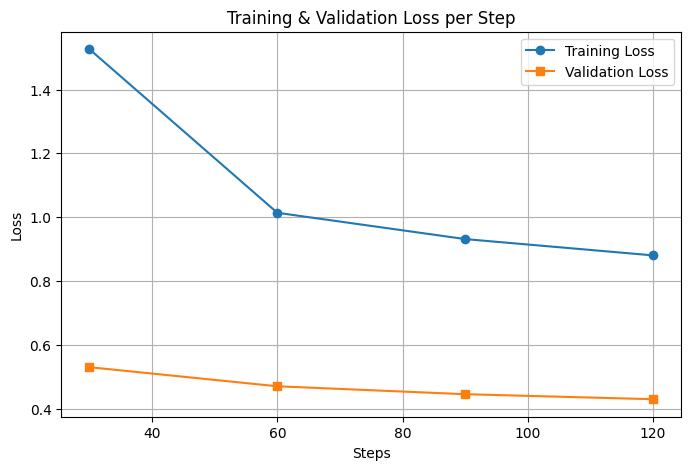

In [10]:
!pip install matplotlib
import matplotlib.pyplot as plt
log_history = trainer.state.log_history

steps = []
train_loss = []
val_loss = []
val_steps = []

for log in log_history:
    if "loss" in log:  # Training loss
        steps.append(log["step"])
        train_loss.append(log["loss"])
    if "eval_loss" in log:  # Validation loss
        val_steps.append(log["step"])
        val_loss.append(log["eval_loss"])
        
plt.figure(figsize=(8, 5))
plt.plot(steps, train_loss, label="Training Loss", marker="o", linestyle="-")
plt.plot(val_steps, val_loss, label="Validation Loss", marker="s", linestyle="-")

plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training & Validation Loss per Step")
plt.legend()
plt.grid(True)
plt.show()


# Load final model after fine-tuning

In [11]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
tokenizer = AutoTokenizer.from_pretrained(model_name)

fine_tuned_model_path = "ESI/final"
base_model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")
model = PeftModel.from_pretrained(base_model, fine_tuned_model_path)
model.eval()


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2ForCausalLM(
      (model): Qwen2Model(
        (embed_tokens): Embedding(151936, 1536)
        (layers): ModuleList(
          (0-27): 28 x Qwen2DecoderLayer(
            (self_attn): Qwen2SdpaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=1536, out_features=1536, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1536, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=1536, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Linea

# Run reference after fine-tuning

In [31]:
prompt_style="""
### Instruction:
You are an expert with advanced knowledge in solving temporal reasoning problems.
Before answering, classify the task given and then create a step-by-step reasoning to ensure a logical and accurate response.
Please answer the following questions.

### Question:
{}
"""

In [42]:
question = "What month is 72 months after December?"
inputs = tokenizer([prompt_style.format(question, "")], return_tensors="pt").to("cuda")

outputs = model.generate(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask,
    max_new_tokens=2080,
    use_cache=True,
)
response = tokenizer.batch_decode(outputs)
print("### Task:" + response[0].split("### Task:")[1])

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


### Task:
ari_month
### Reasoning:
Step 1: Identify the starting month and the shift duration.
Step 2: The starting month is December.
Step 3: The shift duration is 72 months.
Step 4: To find the month 72 months after December, we need to add 72 months to December.
Step 5: We can break down the shift into smaller increments to simplify the calculation. 72 months is equal to 6 years (since 1 year = 12 months).
Step 6: Adding 6 years to December will result in December of the next year.
Step 7: Therefore, 72 months after December is December of the next year.
### Final Answer:
December of the next year.<|endoftext|>


# Upload model to HuggingFace 

In [43]:
!pip install transformers datasets trl huggingface_hub

In [44]:
from huggingface_hub import notebook_login

notebook_login()

In [46]:
from huggingface_hub import HfApi

model_id = "ESITime/Qwen2.5-1.5B-ESI-Time"  # Thay your_username bằng username Hugging Face của bạn
output_dir = "ESI/final"  # Thư mục chứa adapter đã fine-tune

api = HfApi()
api.create_repo(repo_id=model_id, exist_ok=True)
api.upload_folder(
    folder_path=output_dir,
    repo_id=model_id,
    repo_type="model"
)


adapter_model.safetensors:   0%|          | 0.00/37.0M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.50k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ESITime/Qwen2.5-1.5B-ESI-Time/commit/e4d5f21df679b3d72a7cab3ecd00f59905ade918', commit_message='Upload folder using huggingface_hub', commit_description='', oid='e4d5f21df679b3d72a7cab3ecd00f59905ade918', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ESITime/Qwen2.5-1.5B-ESI-Time', endpoint='https://huggingface.co', repo_type='model', repo_id='ESITime/Qwen2.5-1.5B-ESI-Time'), pr_revision=None, pr_num=None)

# Run reference from fine-tuned model on HuggingFace

In [1]:
!pip install transformers datasets trl huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 6.3 MB/s eta 0:00:00a 0:00:01


In [2]:

from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from trl import SFTConfig, SFTTrainer, setup_chat_format
import torch

model_id_ESI = "ESITime/Qwen2.5-7B-instruct-ESITime-checkpoint-480"
model_from_ESI = AutoModelForCausalLM.from_pretrained(
    model_id_ESI,
    device_map="auto",  # Enables multi-GPU support
    torch_dtype=torch.bfloat16,  # Reduce memory usage
)
tokenizer = AutoTokenizer.from_pretrained(model_id_ESI)

prompt_style="""
### Instruction:
You are an expert with advanced knowledge in solving temporal reasoning problems.
Before answering, classify the task given and then create a step-by-step reasoning to ensure a logical and accurate response.
Please answer the following questions.

### Question:
{}
"""

adapter_config.json:   0%|          | 0.00/796 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/27.8k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/80.8M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.33k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

In [6]:
question = "A factory shuts down for maintenance every 90 days. If the last shutdown was on August 15, 2024, when is the next shutdown?"
inputs = tokenizer([prompt_style.format(question, "")], return_tensors="pt").to("cuda")

outputs = model_from_ESI.generate(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask,
    max_new_tokens=2080,
    use_cache=True,
)
response = tokenizer.batch_decode(outputs)
print("### Task:" + response[0].split("### Task:")[1])

### Reasoning:
Step 1: Identify the starting date and the interval of shutdowns.
Step 2: The starting date is August 15, 2024.
Step 3: The interval between shutdowns is 90 days.
Step 4: To find the next shutdown date, add 90 days to the starting date.
Step 5: Calculate the number of days remaining in August. August has 31 days. Days remaining in August = 31 - 15 = 16 days.
Step 6: Subtract the remaining days in August from the total shutdown interval: 90 - 16 = 74 days remaining.
Step 7: Move to the next month, which is September. September has 30 days. Subtract September's days from the remaining days: 74 - 30 = 44 days remaining.
Step 8: Move to the next month, which is October. October has 31 days. Subtract October's days from the remaining days: 44 - 31 = 13 days remaining.
Step 9: Move to the next month, which is November. We have 13 days remaining, so the date will be November 13, 2024.
### Final Answer:
November 13, 2024<|im_end|>
